In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport mutation_features, methylation_pred, somatic_mut_clock, compute_comethylation
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, mutation_features, methylation_pred

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
import colorcet as cc
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV

%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

In [13]:
out_dir = "/cellar/users/zkoch/methylation_and_mutation/analyses"
dependency_f_dir = "/cellar/users/zkoch/methylation_and_mutation/dependency_files"
data_dir = "/cellar/users/zkoch/methylation_and_mutation/data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
#methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation'
methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/processed_methylation'
icgc_dir = "/cellar/users/zkoch/methylation_and_mutation/data/icgc"

# Read TCGA data

In [6]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv"))

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [7]:
# read in other already computed files
mut_in_measured_cpg_w_methyl_age_df = pd.read_parquet(os.path.join(dependency_f_dir, "mut_in_measured_cpg_w_methyl_age_df_5year.parquet"))
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)

# Relationship between age correlation, methyl stdev, and mean mutation count

In [8]:
godmc_meqtls = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/meQTL/goDMC_meQTL/goDMC_meQTLs_for_mutClock.parquet')
mut_feat = mutation_features.mutationFeatures(
    all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = all_methyl_age_df_t, meqtl_db = godmc_meqtls, out_dir = out_dir, 
    consortium = 'TCGA', dataset = 'SKCM', cross_val_num = 1, matrix_qtl_dir = "/cellar/users/zkoch/methylation_and_mutation/data/matrixQtl_data/muts"
    )

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [9]:
# create metrics to sort by from training samples
age_corr = mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index'])
age_corr.drop(['age_at_index', 'gender_MALE', 'gender_FEMALE'], inplace=True)
age_corr = age_corr.to_frame()
age_corr.columns = ['age_corr']

methyl_stdev = mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples].std()
methyl_stdev.drop(['age_at_index', 'gender_MALE', 'gender_FEMALE'], inplace=True)
methyl_stdev = methyl_stdev.to_frame()
methyl_stdev.columns = ['methyl_stdev']

/tmp/ipykernel_337869/2539457098.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  methyl_stdev = mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples].std()


In [10]:
cpg_pred_priority_corr = mut_feat.choose_cpgs_to_train(metric_df = age_corr, bin_size = 50000, sort_by=['age_corr', 'count'], mean = True)

cpg_pred_priority_corr_stdev = cpg_pred_priority_corr.merge(methyl_stdev, left_on = '#id', right_index=True, how='left')
cpg_pred_priority_corr_stdev['abs_age_corr'] = cpg_pred_priority_corr_stdev['age_corr'].abs()


<AxesSubplot:>

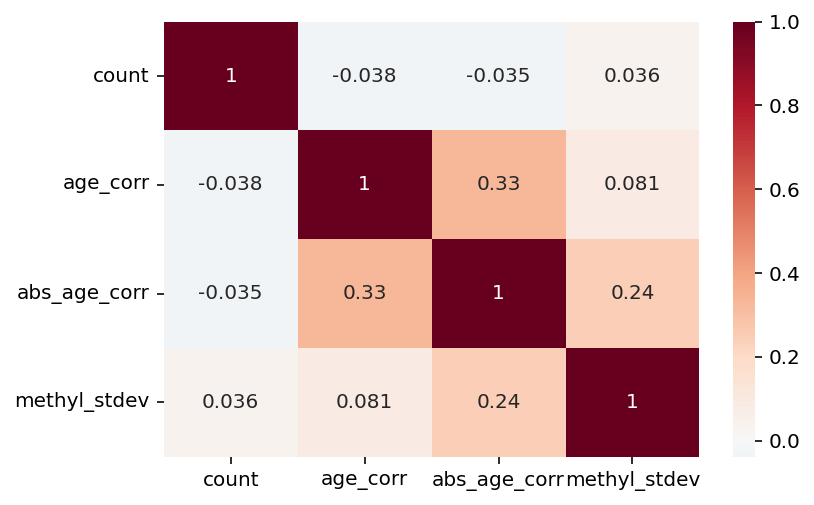

In [11]:
sns.heatmap(cpg_pred_priority_corr_stdev[['count', 'age_corr', 'abs_age_corr', 'methyl_stdev']].corr(), annot=True, cmap='RdBu_r', center=0)

# How many CpGs are necessary?

In [12]:
cpg_groups = []
for num_cpgs in [50000, 150000]: 
    for percentile in [0, .5, 1]:
        for metric in ['abs_age_corr', 'count', 'methyl_stdev']:
            cpg_pred_priority_corr_stdev.sort_values(by=metric, ascending=False, inplace=True)
            # choose num_cpgs from the percentile of the metric
            if percentile == 0: # lowest percentile
                cpgs_to_train = cpg_pred_priority_corr_stdev.iloc[-num_cpgs:, :]['#id'].to_list()
            elif percentile == .5: # middle percentile
                length = cpg_pred_priority_corr_stdev.shape[0]
                cpgs_to_train = cpg_pred_priority_corr_stdev.iloc[
                    int(length/2):int(length/2) + num_cpgs,
                    :]['#id'].to_list()
            elif percentile == 1: # highest percentile
                cpgs_to_train = cpg_pred_priority_corr_stdev.iloc[:num_cpgs, :]['#id'].to_list()
            # create dataframe row
            cpg_groups.append(pd.DataFrame(
                {'num_cpgs': num_cpgs, 'percentile': percentile, 'metric': metric, 'cpgs_to_train': [cpgs_to_train]}))
cpg_groups_df = pd.concat(cpg_groups, ignore_index=True)

In [ ]:
r2s, maes = [], []
for cpg_group in range(cpg_groups_df.shape[0]):
    model = sklearn.linear_model.ElasticNetCV(max_iter=10000, cv=5, n_jobs=-1)
    
    chosen_cpgs = cpg_groups_df.loc[cpg_group, 'cpgs_to_train']
    X = all_methyl_age_df_t.loc[mut_feat.train_samples, chosen_cpgs]
    y = all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index']
    # fit actual methylation values of training samples
    model.fit(X, y)
    # do predictions on test samples
    preds_age = model.predict(mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, chosen_cpgs])
    actual_age = mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index']
    r2s.append(np.corrcoef(preds_age, actual_age)[0,1]**2)
    maes.append(sklearn.metrics.mean_absolute_error(preds_age, actual_age))
    print(f"done {cpg_group}", flush=True)
cpg_groups_df['r2'] = r2s
cpg_groups_df['mae'] = maes

In [22]:
cpg_groups_df.to_parquet(os.path.join(out_dir, "epi_clock_perf_by_feat_group_and_num_5000-150000.parquet"))